In [173]:
import time

import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, transforms
import torch
from torch.utils.data import Subset

In [174]:
# example of loading the mnist dataset
from keras.datasets.mnist import load_data
# load the images into memory
(trainX, trainy), (testX, testy) = load_data()
# summarize the shape of the dataset
print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)


Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


In [175]:
def subset_of_minst(minst_dataset, subset_size=500):
    """Create subset for given dataset"""
    digit_indices = {digit: [] for digit in range(10)}
    
    for idx, (_, target) in enumerate(minst_dataset):
        digit_indices[target].append(idx)
        
    selected_indexes = []
    for digit, indices in digit_indices.items():
        selected_indexes.extend(np.random.choice(indices, subset_size, replace=False))
    
    sub_minst_set = Subset(minst_dataset, selected_indexes)
    return sub_minst_set

In [176]:
INPUT_DIM = 28
BATCH_SIZE = 256
LATENT_DIM = 100

In [177]:


# Define transform to reshape the size of image
img_transforms = transforms.Compose([
    transforms.Resize((INPUT_DIM, INPUT_DIM)),
    transforms.CenterCrop((INPUT_DIM, INPUT_DIM)),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
])

# Download dataset
train_mnist = torchvision.datasets.MNIST(root='.', train=True, download=True, transform=img_transforms)
test_mnist = torchvision.datasets.CIFAR10(root='.', train=False, download=True, transform=img_transforms)

data_size = 2000
train_subset = subset_of_minst(train_mnist, data_size)

# Create a subset dataset from the selected indices

train_loader = torch.utils.data.DataLoader(train_subset, 
                                           batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_mnist, 
                                          batch_size=BATCH_SIZE, shuffle=False)

print(f'Training set {len(train_loader)} has instances')
print(f'test_loader set {len(test_loader)} has instances')

Files already downloaded and verified
Training set 79 has instances
test_loader set 40 has instances


In [178]:
tr = iter(train_loader)
b, data = next(tr)
print(data.shape)
print(b)

torch.Size([256])
tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        ...,


        [[[-1., -1., -1.,  ..., -1., -1., -1.]

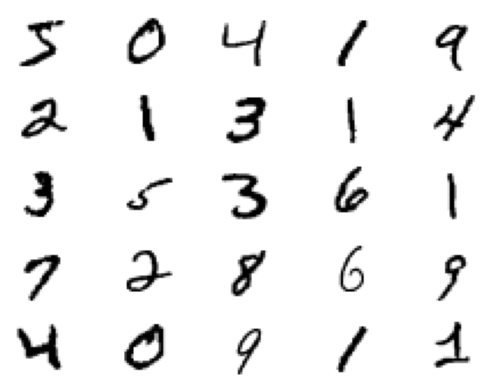

In [179]:
for i in range(25):
 # define subplot
 plt.subplot(5, 5, 1 + i)
 # turn off axis
 plt.axis('off')
 # plot raw pixel data
 plt.imshow(trainX[i], cmap='gray_r')
plt.show()

In [180]:
device = 'cpu'
# Check if MPS is supported and available
if torch.backends.mps.is_available():
    print("MPS is available on this device.")
    device = torch.device("mps")  # Use MPS device
else:
    print("MPS not available, using CPU instead.")
    device = torch.device("cpu")  # Fallback to CPU



MPS is available on this device.


In [181]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Discriminator Net

In [187]:

class CompactDiscriminatorNet(nn.Module):
    
    def __init__(self):
        super(CompactDiscriminatorNet, self).__init__()
        
        self.cons_layers = nn.Sequential(
            nn.Conv2d(3, INPUT_DIM, kernel_size=3, padding=1),
            nn.LeakyReLU(inplace=True),

            nn.Conv2d(32, 32, kernel_size=3),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(inplace=True),

            nn.Conv2d(64, 64, kernel_size=3),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(2304, 512),
            # nn.Linear(1600, 512),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.5),

            nn.Linear(512, 1),
            nn.Sigmoid() 
        )
        
    def forward(self, x):
        x = self.cons_layers(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    
class SimpleDiscriminatorModel(nn.Module):
    
    def __init__(self):
        super(SimpleDiscriminatorModel, self).__init__()
        
        self.cons_layers = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            # nn.Dropout(p=0.4),
            nn.Flatten(),
            nn.Linear(3136, 1),
            nn.Sigmoid() 
        )
        
    def forward(self, x):
        x = self.cons_layers(x)
        return x
    


In [183]:
def generate_true_samples(train_dataset, batch_size=500):
    idx = torch.randint(low=0, high=len(train_dataset), size=(batch_size,))
    X = train_dataset.data[idx]
    X = X.unsqueeze(1)
    print(X.dtype)
    y = torch.ones((batch_size, 1), dtype=torch.float)
    return X, y
    

def generate_false_samples( batch_size=500):
    X = torch.rand(batch_size, 1, INPUT_DIM, INPUT_DIM) 
    y = torch.zeros((batch_size, 1)) 
    return X, y

In [184]:
true_samples = generate_true_samples(train_mnist, batch_size=BATCH_SIZE)
true_samples[0].shape

torch.uint8


torch.Size([256, 1, 28, 28])

In [185]:
import random

def train_discriminator(model, device, train_loader, iters=100):
    # optimizer = torch.optim.Adam(model.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    loss_fn = F.binary_cross_entropy
    # loss_fn = nn.CrossEntropyLoss()
    datalist = []
    for b, data in train_loader:
        datalist.append(b)
        
    for it in range(iters):
        print(f'Iteration {it} / {iters}')
        
        train_data = random.choice(datalist) 
        # print(f'Random batch: {random_batch}')
        # train_data, label = random_batch
        print(f'Training data shape {train_data.shape}')
        # print(f'Label shape {label.shape}')
        # true_samples = generate_true_samples(train_mnist, batch_size=BATCH_SIZE)
        true_samples = (train_data, torch.ones((BATCH_SIZE, 1), dtype=torch.float))

        # # Iterate to the chosen batch index
        # for i, batch in enumerate(train_loader):
        #     if i == random_index:
        #         random_batch = batch
        #         break
        # true_samples = random_batch
        # print(true_samples.shape)
        _, true_acc = train_once(model, true_samples, device, loss_fn, optimizer)
        print(f'\ttrue sample acc: {true_acc}')
        false_samples = generate_false_samples(batch_size=BATCH_SIZE)
        # print(false_samples)
        _, false_acc = train_once(model, false_samples, device, loss_fn, optimizer)
        print(f'\tfalse sample acc: {false_acc}')
        

def train_once(model, samples, device, loss_fn, optimizer):
    inputs, labels = samples
    inputs = inputs.to(device)
    labels = labels.to(device)
    # clear gradient
    optimizer.zero_grad()
    outputs = model(inputs)
    # outputs = outputs.squeeze()
    # print(f'output: {outputs}')
    # print(outputs)
    # loss
    # print(labels.shape)
    loss = loss_fn(outputs, labels)
    loss.backward()
    # update parameters
    optimizer.step()
    predicted = outputs > 0.5  # Threshold logits at 0 for classification
    correct = (predicted == labels).float().sum()
    acc = correct / inputs.size(0)
    loss = loss.item()
    return loss, acc

In [209]:
d_model = SimpleDiscriminatorModel()
d_model.to(device)

train_discriminator(d_model, device, train_loader, iters=50)

Iteration 0 / 50
Training data shape torch.Size([256, 1, 28, 28])
	true sample acc: 0.28515625
	false sample acc: 0.5
Iteration 1 / 50
Training data shape torch.Size([256, 1, 28, 28])
	true sample acc: 0.9296875
	false sample acc: 0.8359375
Iteration 2 / 50
Training data shape torch.Size([256, 1, 28, 28])
	true sample acc: 1.0
	false sample acc: 0.99609375
Iteration 3 / 50
Training data shape torch.Size([256, 1, 28, 28])
	true sample acc: 1.0
	false sample acc: 1.0
Iteration 4 / 50
Training data shape torch.Size([256, 1, 28, 28])
	true sample acc: 1.0
	false sample acc: 1.0
Iteration 5 / 50
Training data shape torch.Size([256, 1, 28, 28])
	true sample acc: 1.0
	false sample acc: 1.0
Iteration 6 / 50
Training data shape torch.Size([256, 1, 28, 28])
	true sample acc: 1.0
	false sample acc: 1.0
Iteration 7 / 50
Training data shape torch.Size([256, 1, 28, 28])
	true sample acc: 1.0
	false sample acc: 1.0
Iteration 8 / 50
Training data shape torch.Size([256, 1, 28, 28])
	true sample acc: 1.

# Generator Model

In [189]:
class CompactGeneratorNet(nn.Module):
    
    def __init__(self):
        super(CompactGeneratorNet, self).__init__()
        self.cons_layers = nn.Sequential(
            nn.Linear(LATENT_DIM, 128 * 7 * 7),
            nn.ReLU(inplace=True),
            
            nn.Unflatten(1, (128, 7, 7)),  # Corrected dimension ordering
            
            # upsample to 16 * 16
            nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            
            # upsample to 32 * 32
            nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(128, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.cons_layers(x)
        return x
    
class SimpleGeneratorModel(nn.Module):
    
    def __init__(self):
        super(SimpleGeneratorModel, self).__init__()
        self.cons_layers = nn.Sequential(
            nn.Linear(LATENT_DIM, 128 * 7 * 7),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Unflatten(1, (128, 7, 7)),  # Corrected dimension ordering
            
            # upsample to 16 * 16
            nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True),
            
            # upsample to 32 * 32
            nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True),
            
            nn.Conv2d(128, 1, kernel_size=3, padding=1),
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.cons_layers(x)
        return x

In [191]:
def generate_latent_point(n_samples, latent_dim):
    x = torch.randn(n_samples, latent_dim)
    return x

In [190]:
generate_latent_point(BATCH_SIZE, LATENT_DIM).shape

torch.Size([256, 100])

In [192]:
def generate_false_samples_v2(g_model, device, batch_size=500, latent_dim=100):
    X = generate_latent_point(batch_size, latent_dim)
    # print(f'Latent Points: {X.shape}')
    X = X.to(device)
    X = g_model(X)
    y = torch.zeros((batch_size, 1)) 
    X = X.to(device)
    y = y.to(device)
    # print(f'False sample: {X.shape}, y: {y.shape}')
    return X, y

In [193]:
g_model = SimpleGeneratorModel()
g_model.to(device)

gen_ret = generate_false_samples_v2(g_model, device, BATCH_SIZE, LATENT_DIM)[0]
gen_ret.shape

torch.Size([256, 1, 28, 28])

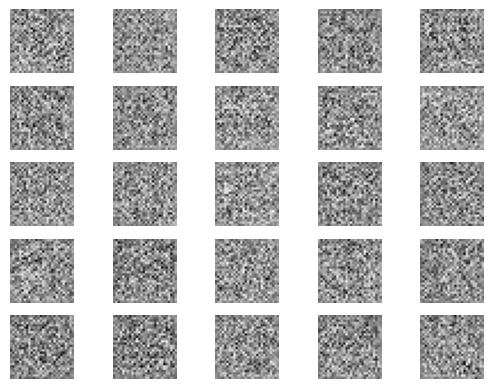

In [194]:
for i in range(25):
 # define subplot
 plt.subplot(5, 5, 1 + i)
 # turn off axis
 plt.axis('off')
 # plot raw pixel data
 plt.imshow(gen_ret[i, 0, :, :].detach().cpu().numpy(), cmap='gray_r')
plt.show()

# Train Generator Model

In [121]:
class GAN(nn.Module):
    
    def __init__(self, generator, discriminator):
        super(GAN, self).__init__()
        
        self.gan = nn.Sequential(
            generator,
            discriminator
        )
        
        
    def forward(self, x):
        return self.gan(x) 
        

In [122]:
gan_model = GAN(g_model, d_model)
gan_model.to(device)

GAN(
  (gan): Sequential(
    (0): CompactGeneratorNet(
      (cons_layers): Sequential(
        (0): Linear(in_features=100, out_features=6272, bias=True)
        (1): ReLU(inplace=True)
        (2): Unflatten(dim=1, unflattened_size=(128, 7, 7))
        (3): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (4): ReLU(inplace=True)
        (5): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (6): ReLU(inplace=True)
        (7): Conv2d(128, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (8): Sigmoid()
      )
    )
    (1): SimpleDiscriminatorModel(
      (cons_layers): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.01, inplace=True)
        (2): Dropout(p=0.4, inplace=False)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (4): LeakyReLU(negative_slope=0.01, inplace=True)
        

In [195]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

def save_plot(samples, epoch, n = 10):
    # plot images
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(samples[i, 0, :, :].detach().cpu().numpy().reshape(INPUT_DIM, INPUT_DIM), cmap='gray_r')
	# save plot to file
	filename = './generated_plot_e%03d.png' % (epoch+1)
	plt.savefig(filename)
	plt.close()

def summarize_performance(epoch, g_model, d_model, test_loader, device, batch_size, latent_dim=100):
    X_false, y_false = generate_false_samples_v2(g_model, device, batch_size, latent_dim)
    X_false = X_false.to(device)
    y_false = y_false.to(device)
    
    # Test model
    # test_model(X_false, batch_size, d_model, device, epoch, test_loader, y_false)

    # Plot images
    save_plot(X_false, epoch)


def test_model(X_false, batch_size, d_model, device, epoch, test_loader, y_false):
    avg_true_acc = 0.
    with torch.no_grad():
        for b, data in enumerate(test_loader):
            test_inputs, _ = data
            test_inputs = test_inputs.to(device)
            # test_labels = test_labels.to(device)

            test_labels = torch.ones((batch_size, 1), dtype=torch.float).to(device)

            test_outputs = d_model(test_inputs)

            # Accuracy
            predicted = test_outputs > 0.5  # Threshold logits at 0 for classification
            correct = (predicted == test_labels).float().sum()

            acc = correct / test_outputs.size(0)

            avg_true_acc += acc.cpu()
        avg_true_acc = avg_true_acc / len(test_loader)
    false_outputs = d_model(X_false)
    false_predictd = (false_outputs > 0.5).to(device)
    false_correct = (false_predictd == y_false).float().sum()
    false_acc = false_correct / len(X_false)
    print(f'\tEpoch[{epoch}] True acc: {avg_true_acc:.4f}, False acc: {false_acc:.4f}')


def discriminator_loss(output_true, output_fake):
    true_loss = F.binary_cross_entropy(output_true, torch.ones_like(output_true))
    fake_loss = F.binary_cross_entropy(output_fake, torch.zeros_like(output_fake))
    total_loss = true_loss + fake_loss
    return total_loss

def generator_loss(output_fake):
    generated_loss = F.binary_cross_entropy(output_fake, torch.ones_like(output_fake))
    return generated_loss
    
    

def train_gan(g_model, d_model, gan_model, train_loader, device, epochs=100, batch_size=500, latent_dim=100):
    optimizer_g = torch.optim.Adam(g_model.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_d = torch.optim.Adam(d_model.parameters(), lr=0.0002, betas=(0.5, 0.999))
    print(device)
    for epoch in range(epochs):
        for b, batch_dataset in enumerate(train_loader):
            X_true, _ = batch_dataset
            X_true = X_true.to(device)
            
            y_true = torch.ones((batch_size, 1), dtype=torch.float)
            y_true = y_true.to(device)
            
            # Phase 1: Discriminating: Focusing on updating discriminator
            ## Generate false samples with a trained generator
            
            X_false, y_false = generate_false_samples_v2(g_model, device, batch_size, latent_dim)
            
            # print(f'\tY shape, true: {y_true.shape}, false: {y_false.shape}')
            optimizer_d.zero_grad()
            d_true = d_model(X_true)
            # print(f'D model output shape: {d_true.shape}')
            
            true_loss = F.binary_cross_entropy(d_true, torch.ones_like(d_true))
            true_loss.backward()
            d_x = d_true.mean().item() # Loss of D(x)
            
            d_fake = d_model(X_false.detach())
            fake_loss = F.binary_cross_entropy(d_fake, torch.zeros_like(d_fake))
            fake_loss.backward()
            d_g_z1 = d_fake.mean().item()
            
            d_loss = true_loss + fake_loss
            optimizer_d.step()
            
            # Phase 2: Polishing fake examples: Focusing on updating generator
            # X_false, y_false = generate_false_samples_v2(g_model, device, batch_size * 2, latent_dim) 
            optimizer_g.zero_grad()
            g_fake = d_model(X_false)
            g_loss = F.binary_cross_entropy(g_fake, torch.ones_like(g_fake))
            g_loss.backward()
            d_g_z2 = g_fake.mean().item()
            optimizer_g.step()
            
            print(f'Epoch[{epoch}], Batch[{b}] Loss G: {g_loss:.4f}, Loss D: {d_loss:.4f}, D(x): {d_x:.4f}, D(G(z1)): {d_g_z1:.4f}, D(G(z2)): {d_g_z2:.4f}')
        
        if (epoch + 1) % 10 == 0:
            # Plot performance every 5 epoch
            summarize_performance(epoch, g_model, d_model, test_loader, device, batch_size, latent_dim)
            
            

# Plot samples

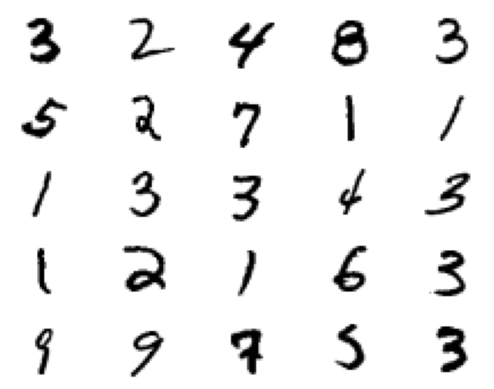

In [124]:
t_iter = iter(train_loader)
dataseet, labels = next(t_iter)
n = 5
for i in range(n * n):
    # define subplot
	plt.subplot(n, n, 1 + i)
		# turn off axis
	plt.axis('off')
		# plot raw pixel data
	plt.imshow(dataseet[i, 0, :, :].detach().cpu().numpy().reshape(INPUT_DIM, INPUT_DIM), cmap='gray_r')

		

In [196]:
d_model = SimpleDiscriminatorModel()
d_model.to(device)
d_model.apply(weights_init)

g_model = SimpleGeneratorModel()
g_model.to(device)
g_model.apply(weights_init)

gan_model = GAN(g_model, d_model)
gan_model.to(device)

train_gan(g_model, d_model, gan_model, train_loader, device, epochs=40, batch_size=BATCH_SIZE, latent_dim=LATENT_DIM)

mps
Epoch[0], Batch[0] Loss G: 0.5092, Loss D: 1.6447, D(x): 0.6593, D(G(z1)): 0.7043, D(G(z2)): 0.6024
Epoch[0], Batch[1] Loss G: 0.5846, Loss D: 1.5673, D(x): 0.6194, D(G(z1)): 0.6603, D(G(z2)): 0.5587
Epoch[0], Batch[2] Loss G: 0.6841, Loss D: 1.4498, D(x): 0.5888, D(G(z1)): 0.5985, D(G(z2)): 0.5059
Epoch[0], Batch[3] Loss G: 0.7532, Loss D: 1.3639, D(x): 0.5740, D(G(z1)): 0.5507, D(G(z2)): 0.4724
Epoch[0], Batch[4] Loss G: 0.8266, Loss D: 1.2818, D(x): 0.5738, D(G(z1)): 0.5122, D(G(z2)): 0.4392
Epoch[0], Batch[5] Loss G: 0.8994, Loss D: 1.1838, D(x): 0.5873, D(G(z1)): 0.4742, D(G(z2)): 0.4083
Epoch[0], Batch[6] Loss G: 0.9693, Loss D: 1.1078, D(x): 0.5999, D(G(z1)): 0.4428, D(G(z2)): 0.3816
Epoch[0], Batch[7] Loss G: 0.9989, Loss D: 1.0559, D(x): 0.6139, D(G(z1)): 0.4272, D(G(z2)): 0.3704
Epoch[0], Batch[8] Loss G: 1.0330, Loss D: 0.9927, D(x): 0.6459, D(G(z1)): 0.4198, D(G(z2)): 0.3581
Epoch[0], Batch[9] Loss G: 1.0770, Loss D: 0.9560, D(x): 0.6590, D(G(z1)): 0.4095, D(G(z2)): 0.3

# Generate Images

## Generate a bunch of images

In [197]:
n = 5
latent_points = generate_latent_point(n * n, 100)
latent_points = latent_points.to(device)
# generate images
g_rets = g_model(latent_points)
g_rets = g_rets.to(device)



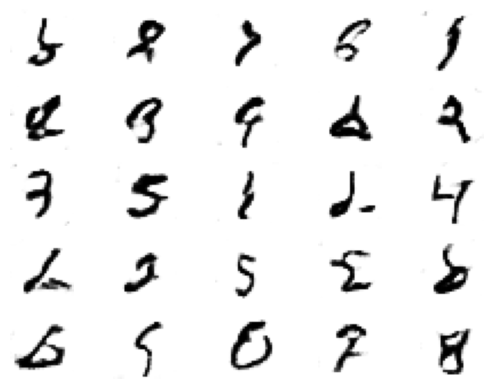

In [199]:
# plot images
for i in range(n * n):
	# define subplot
	plt.subplot(n, n, 1 + i)
	# turn off axis
	plt.axis('off')
	# plot raw pixel data
	plt.imshow(g_rets[i, 0, :, :].detach().cpu().numpy().reshape(INPUT_DIM, INPUT_DIM), cmap='gray_r')

## Generate a image from zero

In [203]:
latent_point = torch.zeros(1, 100).to(device)
latent_point

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.]], device='mps:0')

In [206]:
import time
start_ts = time.time()
zerop_output = g_model(latent_point)

end_ts = time.time()
print(f'Time taken to generate a image: {end_ts - start_ts} (ms)')

Time taken to generate latent points: 0.007181882858276367


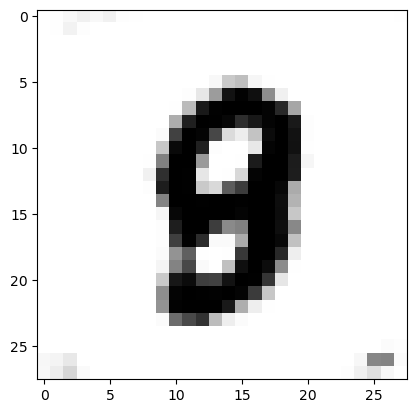

In [207]:
plt.imshow(zerop_output[0, 0, :, :].detach().cpu().numpy().reshape(INPUT_DIM, INPUT_DIM), cmap='gray_r')